In [1]:
import ctypes
from ctypes.util import find_library

def unload_lib(lib):
    """Unload the loaded CDLL library from memory."""
    if not hasattr(lib, "_handle"):
        raise ValueError("Object is not a loaded CDLL library.")
    
    # Ищем libdl
    libdl_path = find_library("dl")
    if not libdl_path:
        raise RuntimeError("libdl not found — unloading .so is not possible.")
    
    libdl = ctypes.CDLL(libdl_path)

    dlclose = libdl.dlclose
    dlclose.argtypes = [ctypes.c_void_p]
    dlclose.restype = ctypes.c_int

    handle = lib._handle
    ret = dlclose(handle)

    if ret == 0:
        print(f"✅ Library {lib._name} unloaded from memory.")
        return True
    else:
        # you can call ctypes.get_errno(), but dlclose does not set errno on all systems
        print(f"❌ dlclose returned code {ret}. Library may not be unloaded.")
        return False

In [2]:
# after loading:
#lib = ctypes.CDLL("./mendrive_det.so")

# ... work ...

# before recompilation:
if 'lib' in locals():
    unload_lib(lib)
    del lib
    import gc; gc.collect()

# we recompile
#!gcc -shared -fPIC -O3 -o mendrive_det.so mendrive_det.c -lm

# we load again
#lib = ctypes.CDLL("./mendrive_det.so")

In [3]:
def compile_lib(name):
    import os 
    # Command to execute -lgsl -lgslcblas -lm
    # cmd = "gcc -shared -fPIC -O3 -o {name}.so {name}.c -lm".format(name=name)
    
    cmd = """gcc -shared -fPIC -O3 -o {name}.so \
        {name}.c \
        -DINCLUDE_CUBA_H \
        -I./local/include \
        -L./local/lib \
        -Wl,-rpath='\\$ORIGIN/local/lib' \
        -lcuba -lm
    """.format(name=name)

    # Using os.system() method
    os.system(cmd)

In [4]:
compile_lib("calc_longitudinal_sphere_mass")

In [5]:
def load_and_init_lib(name):
    import ctypes
    from ctypes import Structure, c_double, c_int, c_longdouble, POINTER, CDLL, byref

    # Loading the library
    lib = CDLL("./{name}.so".format(name=name))

    # Function binding
    lib.integrate.argtypes = [
        c_double, # R0,       /* Радиус сферы */
        c_double, # v0,       /* Начальная продольная скорость */
        c_double, # a,        /* Продольное ускорение */
        c_double, # c,        /* Скорость света */
        c_double, # t,        /* Текущее время */
        c_double, # t0,       /* Начальное время */
        c_int,    # use_delay,
        c_int,    # use_lorentz_factor,
        c_int,    # use_lorentz_general_factor,
        c_int,    # use_fermi_factor_O,
        c_int,    # use_fermi_factor,
        c_int,    # use_fermi_general_factor,
        c_int,    # use_fast_integrand,
        POINTER(c_double), # cubareal* integral
        POINTER(c_double), # cubareal* error
        POINTER(c_double), # cubareal* prob)
    ]
    lib.integrate.restype  = c_int

   
    return lib

# Function call:
def c_integrate(lib,
                R0,       # /* Радиус сферы */
                v0,       # /* Начальная продольная скорость */
                a,        # /* Продольное ускорение */
                c,        # /* Скорость света */
                t,        # /* Текущее время */
                t0,       # /* Начальное время */
                use_delay,
                use_lorentz_factor,
                use_lorentz_general_factor,
                use_fermi_factor_O,
                use_fermi_factor,
                use_fermi_general_factor,
                use_fast_integrand):

    import ctypes
    from ctypes import c_int,  c_double,  POINTER, byref
    import numpy as np

    NCOMP = 9
    integ = np.zeros(NCOMP, dtype=np.float64)
    error = np.zeros(NCOMP, dtype=np.float64)
    prob  = np.zeros(NCOMP, dtype=np.float64)

    lib.integrate(c_double(R0),
                  c_double(v0),
                  c_double(a),
                  c_double(c),
                  c_double(t),
                  c_double(t0),
                  c_int(use_delay),
                  c_int(use_lorentz_factor),
                  c_int(use_lorentz_general_factor),
                  c_int(use_fermi_factor_O),
                  c_int(use_fermi_factor),
                  c_int(use_fermi_general_factor),
                  c_int(use_fast_integrand),
                  integ.ctypes.data_as(POINTER(c_double)),
                  error.ctypes.data_as(POINTER(c_double)),
                  prob.ctypes.data_as(POINTER(c_double))
    )
    
    result_names = [
        "observed_ratio_1_x ",
        "observed_ratio_1_y ",
        "observed_ratio_1_z ",
        "observed_ratio_2_x ",
        "observed_ratio_2_y ",
        "observed_ratio_2_z ",
        "observed_ratio_x   ",
        "observed_ratio_y   ",
        "observed_ratio_z   "];
    for comp in range(0, 9):
        print(result_names[comp], integ[comp], error[comp], prob[comp])
        
    return integ, error, prob

In [6]:
lib = load_and_init_lib("calc_longitudinal_sphere_mass")

In [7]:
def calc_longitudinal_sphere_mass(a,
                                  use_delay,
                                  use_lorentz_factor,
                                  use_fermi_factor):
    R0  = 1;      # /* радиус сферы (половина R1) */
    v0  = 0
    c   = 1;      # /* скорость света в м/с */
    v_c = v0 / c; # /* отношение скорости заряда к скорости света*/
    t   = 0
    t0  = 0

    # use_delay                  = 1;
    # use_lorentz_factor         = 1;
    use_lorentz_general_factor = 0;
    use_fermi_factor_O         = 0;
    # use_fermi_factor           = 0;
    use_fermi_general_factor   = 0;
    use_fast_integrand         = 1;

    integ, error, prob = c_integrate(lib,
                R0,  #   /* Радиус сферы */
                v0,  #   /* Радиус орбиты */
                a,   #   /* Угловая скорость */
                c,   #   /* Скорость света */
                t,
                t0,
                use_delay,
                use_lorentz_factor,
                use_lorentz_general_factor,
                use_fermi_factor_O,
                use_fermi_factor,
                use_fermi_general_factor,
                use_fast_integrand)
    return integ[2], integ[5], integ[8], v_c.n()

In [8]:
mass_array                  = []
mass_fermi_array            = []
mass_hysteresis_array       = []
mass_hysteresis_lw_array    = []
mass_hysteresis_fermi_array = []

In [9]:
def append_mass_hysteresis(va):
    global mass_array
    global mass_fermi_array
    global mass_hysteresis_array
    global mass_hysteresis_lw_array
    global mass_hysteresis_fermi_array

    for a in va:
        observed_ratio_1_z, observed_ratio_2_z, observed_ratio_z, v_c \
            = calc_longitudinal_sphere_mass(a = a, \
                                          use_delay = 1, \
                                          use_lorentz_factor = use_lorentz_factor, \
                                          use_fermi_factor = 0)
        m1 = observed_ratio_1_z
        m2 = observed_ratio_2_z
        m = observed_ratio_z
        observed_ratio_1_z, observed_ratio_2_z, observed_ratio_z, v_c \
            = calc_longitudinal_sphere_mass(a = a, 
                                          use_delay = 1, \
                                          use_lorentz_factor = use_lorentz_factor, \
                                          use_fermi_factor = 1)
        m1_f = observed_ratio_1_z
        m2_f = observed_ratio_2_z
        m_f = observed_ratio_z

        mass_array += [(a, m1, m2)]
        mass_fermi_array += [(a, m1_f, m2_f)]
        mass_hysteresis_array += [(a, m, m_f)]
        mass_hysteresis_lw_array += [(a, m)]
        mass_hysteresis_fermi_array += [(a, m_f)]

In [10]:
use_lorentz_factor = 0

In [11]:
append_mass_hysteresis([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,
                        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2,
                        0.21, 0.22, 0.23, 0.24, 0.25, 0.26])

Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.0167914 +- 0.0408942  	chisq 0 (0 df)
[2] -0.0201197 +- 0.0368818  	chisq 0 (0 df)
[3] 0.62799 +- 0.0536068  	chisq 0 (0 df)
[4] 0 +- 7.02518e-18  	chisq 0 (0 df)
[5] 0 +- 7.02518e-18  	chisq 0 (0 df)
[6] -2.00822 +- 0.138614  	chisq 0 (0 df)
[7] -0.0167914 +- 0.0408942  	chisq 0 (0 df)
[8] -0.0201197 +- 0.0368818  	chisq 0 (0 df)
[9] -1.3803 +- 0.109565  	chisq 0 (0 df)

Iteration 2:  2500 integrand evaluations so far
[1] -0.00779544 +- 0.0168001  	chisq 0.0582171 (1 df)
[2] -0.00153184 +- 0.0173458  	chisq 0.326139 (1 df)
[3] 0.647569 +- 0.0225005  	chisq 0.161926 (1 df)
[4] 0 +- 4.44267e-18  	chisq 0 (1 df)
[5] 0 +- 4.44267e-18  	chisq 0 (1 df)
[6] -2.00581 +- 0.053396  	chisq 0.000355649 (1 df)
[7] -0.00779544 +- 0.0168001  


Iteration 42:  472500 integrand evaluations so far
[1] -0.00702763 +- 0.00113491  	chisq 5.48558 (41 df)
[2] 0.000180653 +- 0.000741955  	chisq 8.61341 (41 df)
[3] 0.666787 +- 0.00106146  	chisq 7.25056 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.00045 +- 0.0024949  	chisq 2.43581 (41 df)
[7] -0.00702763 +- 0.00113491  	chisq 5.48558 (41 df)
[8] 0.000180653 +- 0.000741955  	chisq 8.61341 (41 df)
[9] -1.33359 +- 0.00228047  	chisq 2.34212 (41 df)

Iteration 43:  494500 integrand evaluations so far
[1] -0.00706502 +- 0.00111198  	chisq 5.51272 (42 df)
[2] 0.000156406 +- 0.000725228  	chisq 8.63736 (42 df)
[3] 0.666893 +- 0.00104267  	chisq 7.53441 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.00067 +- 0.0024475  	chisq 2.65542 (42 df)
[7] -0.00706502 +- 0.00111198  	chisq 5.51272 (42 df)
[8] 0.000156406 +- 0.000725228  	chisq 8.63736 (42 df)
[9] -1.33372 +- 0.00223415  	chisq 2.41788 (42 df)



Iteration 44:  517000 integrand evaluations so far
[1] -0.00957071 +- 0.00163456  	chisq 5.06008 (43 df)
[2] 0.000172378 +- 0.001064  	chisq 8.56574 (43 df)
[3] 1.00018 +- 0.00152794  	chisq 7.04738 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.00054 +- 0.00239565  	chisq 2.83027 (43 df)
[7] -0.00957071 +- 0.00163456  	chisq 5.06008 (43 df)
[8] 0.000172378 +- 0.001064  	chisq 8.56574 (43 df)
[9] -1.00008 +- 0.00225928  	chisq 3.53043 (43 df)
observed_ratio_1_x  -0.00957070956653762 0.0016345616528191185 1.7499581090477913e-13
observed_ratio_1_y  0.00017237786282646935 0.001064002966918808 2.7284039354113946e-09
observed_ratio_1_z  1.0001754280419437 0.0015279366164007663 8.440981082061466e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0005373260250408 0.0023956517903242036 0.0
observed_ratio_x    -0.009570709566537619 0.0016345616528191185 1.7466223815584423


Iteration 34:  314500 integrand evaluations so far
[1] -0.013555 +- 0.00143408  	chisq 7.18908 (33 df)
[2] 0.000153737 +- 0.000908245  	chisq 7.94921 (33 df)
[3] 0.667558 +- 0.00133622  	chisq 5.75317 (33 df)
[4] 0 +- 3.95962e-19  	chisq 0 (33 df)
[5] 0 +- 3.95962e-19  	chisq 0 (33 df)
[6] -2.00172 +- 0.00319873  	chisq 2.08917 (33 df)
[7] -0.013555 +- 0.00143408  	chisq 7.18908 (33 df)
[8] 0.000153737 +- 0.000908245  	chisq 7.94921 (33 df)
[9] -1.3342 +- 0.00288805  	chisq 3.32477 (33 df)

Iteration 35:  332500 integrand evaluations so far
[1] -0.0135948 +- 0.0013879  	chisq 7.20123 (34 df)
[2] 0.00016591 +- 0.000882702  	chisq 7.95245 (34 df)
[3] 0.66757 +- 0.00129425  	chisq 5.75443 (34 df)
[4] 0 +- 3.85094e-19  	chisq 0 (34 df)
[5] 0 +- 3.85094e-19  	chisq 0 (34 df)
[6] -2.00148 +- 0.00308977  	chisq 2.17272 (34 df)
[7] -0.0135948 +- 0.0013879  	chisq 7.20123 (34 df)
[8] 0.00016591 +- 0.000882702  	chisq 7.95245 (34 df)
[9] -1.33398 +- 0.00279652  	chisq 3.42002 (34 df)

Iteration


Iteration 32:  280000 integrand evaluations so far
[1] -0.0191378 +- 0.00225717  	chisq 5.73171 (31 df)
[2] 0.000309144 +- 0.0014501  	chisq 8.32927 (31 df)
[3] 1.00035 +- 0.00209273  	chisq 4.98813 (31 df)
[4] 0 +- 4.19649e-19  	chisq 0 (31 df)
[5] 0 +- 4.19649e-19  	chisq 0 (31 df)
[6] -2.00136 +- 0.00334893  	chisq 2.14158 (31 df)
[7] -0.0191378 +- 0.00225717  	chisq 5.73171 (31 df)
[8] 0.000309144 +- 0.0014501  	chisq 8.32927 (31 df)
[9] -1.00109 +- 0.00312282  	chisq 3.41278 (31 df)

Iteration 33:  297000 integrand evaluations so far
[1] -0.0188749 +- 0.00219022  	chisq 5.96387 (32 df)
[2] 0.000320546 +- 0.00140578  	chisq 8.3303 (32 df)
[3] 1.00061 +- 0.00203577  	chisq 5.26511 (32 df)
[4] 0 +- 4.07461e-19  	chisq 0 (32 df)
[5] 0 +- 4.07461e-19  	chisq 0 (32 df)
[6] -2.00131 +- 0.00325107  	chisq 2.14596 (32 df)
[7] -0.0188749 +- 0.00219022  	chisq 5.96387 (32 df)
[8] 0.000320546 +- 0.00140578  	chisq 8.3303 (32 df)
[9] -1.00077 +- 0.0030327  	chisq 3.59386 (32 df)

Iteration 34


Iteration 38:  389500 integrand evaluations so far
[1] -0.0209595 +- 0.00128274  	chisq 8.59673 (37 df)
[2] 0.000183861 +- 0.00081768  	chisq 8.19612 (37 df)
[3] 0.669735 +- 0.00119332  	chisq 6.12648 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.00393 +- 0.00285448  	chisq 2.48601 (37 df)
[7] -0.0209595 +- 0.00128274  	chisq 8.59673 (37 df)
[8] 0.000183861 +- 0.00081768  	chisq 8.19612 (37 df)
[9] -1.33457 +- 0.00258495  	chisq 3.62821 (37 df)

Iteration 39:  409500 integrand evaluations so far
[1] -0.0209244 +- 0.00125092  	chisq 8.61194 (38 df)
[2] 0.000116744 +- 0.000796895  	chisq 8.33035 (38 df)
[3] 0.669652 +- 0.00116207  	chisq 6.21899 (38 df)
[4] 0 +- 3.47004e-19  	chisq 0 (38 df)
[5] 0 +- 3.47004e-19  	chisq 0 (38 df)
[6] -2.00396 +- 0.00278505  	chisq 2.48797 (38 df)
[7] -0.0209244 +- 0.00125092  	chisq 8.61194 (38 df)
[8] 0.000116744 +- 0.000796895  	chisq 8.33035 (38 df)
[9] -1.33467 +- 0.00252343  	chisq 3.66569 (38 df)

Ite


Iteration 44:  517000 integrand evaluations so far
[1] -0.0286277 +- 0.00167916  	chisq 8.61676 (43 df)
[2] 0.000211534 +- 0.0010601  	chisq 8.65812 (43 df)
[3] 1.00273 +- 0.00155259  	chisq 6.72501 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.00308 +- 0.00249713  	chisq 2.79476 (43 df)
[7] -0.0286277 +- 0.00167916  	chisq 8.61676 (43 df)
[8] 0.000211534 +- 0.0010601  	chisq 8.65812 (43 df)
[9] -1.00074 +- 0.00231401  	chisq 5.25128 (43 df)
observed_ratio_1_x  -0.028627694666744197 0.0016791610446186469 3.0260337438767725e-09
observed_ratio_1_y  0.00021153400910520046 0.0010601008794295407 3.2892094978275535e-09
observed_ratio_1_z  1.0027310788542239 0.0015525913174265556 3.594141148766526e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0030757255392437 0.002497127838350394 0.0
observed_ratio_x    -0.028627694666744204 0.0016791610446186469 3.026033761583124

observed_ratio_1_x  -0.028049745740528403 0.001116680230681655 1.2532163662884039e-09
observed_ratio_1_y  0.00013862408752408483 0.0007102703291919747 3.6269769750154165e-08
observed_ratio_1_z  0.6719946898726866 0.0010460698374696203 4.209776551432181e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0069775547320847 0.002490874328152993 0.0
observed_ratio_x    -0.028049745740528403 0.0011166802306816549 1.2532165969768014e-09
observed_ratio_y    0.00013862408752408488 0.0007102703291919747 3.626976981000292e-08
observed_ratio_z    -1.3357039557641412 0.002251184116529027 1.5206898146661437e-15
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.0530036 +- 0.0614965  	chisq 0 (0 df)
[2] -0.0302957 +- 


Iteration 38:  389500 integrand evaluations so far
[1] -0.038382 +- 0.001925  	chisq 8.26707 (37 df)
[2] 0.000253277 +- 0.00122825  	chisq 8.36513 (37 df)
[3] 1.00497 +- 0.00178818  	chisq 5.47821 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.00552 +- 0.00285882  	chisq 2.27337 (37 df)
[7] -0.038382 +- 0.001925  	chisq 8.26707 (37 df)
[8] 0.000253277 +- 0.00122825  	chisq 8.36513 (37 df)
[9] -1.00133 +- 0.0026559  	chisq 4.34223 (37 df)

Iteration 39:  409500 integrand evaluations so far
[1] -0.0383411 +- 0.00187694  	chisq 8.27619 (38 df)
[2] 0.000145642 +- 0.00119718  	chisq 8.51889 (38 df)
[3] 1.00485 +- 0.00174132  	chisq 5.55321 (38 df)
[4] 0 +- 3.47004e-19  	chisq 0 (38 df)
[5] 0 +- 3.47004e-19  	chisq 0 (38 df)
[6] -2.00555 +- 0.00278873  	chisq 2.27514 (38 df)
[7] -0.0383411 +- 0.00187694  	chisq 8.27619 (38 df)
[8] 0.000145642 +- 0.00119718  	chisq 8.51889 (38 df)
[9] -1.00147 +- 0.00259208  	chisq 4.39601 (38 df)

Iteration 40: 


Iteration 44:  517000 integrand evaluations so far
[1] -0.0350119 +- 0.00112843  	chisq 7.84741 (43 df)
[2] 4.85193e-05 +- 0.000716467  	chisq 9.48972 (43 df)
[3] 0.674906 +- 0.0010573  	chisq 6.19043 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.01119 +- 0.00253627  	chisq 3.05549 (43 df)
[7] -0.0350119 +- 0.00112843  	chisq 7.84741 (43 df)
[8] 4.85193e-05 +- 0.000716467  	chisq 9.48972 (43 df)
[9] -1.33754 +- 0.00228361  	chisq 4.40548 (43 df)
observed_ratio_1_x  -0.03501192256946071 0.0011284291253405379 5.831392981308831e-10
observed_ratio_1_y  4.8519343026700056e-05 0.0007164666864131526 1.594600503755748e-08
observed_ratio_1_z  0.6749060492481046 0.0010572951122120938 7.804281287307147e-12
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0111854869960837 0.002536269701782974 0.0
observed_ratio_x    -0.03501192256946071 0.001128429125340538 5.831393675761974e

observed_ratio_1_x  -0.048028491258569714 0.001678626484789897 2.3281592338406377e-09
observed_ratio_1_y  0.0002550691743725067 0.0010666339717762166 9.289773521868504e-08
observed_ratio_1_z  1.0077367753830588 0.0015702240870765173 1.940822116020356e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0087808567584333 0.0025007398642693532 0.0
observed_ratio_x    -0.0480284912585697 0.0016786264847898965 2.328159007672511e-09
observed_ratio_y    0.0002550691743725071 0.0010666339717762163 9.289773521868504e-08
observed_ratio_z    -1.002193782308566 0.00231486037763194 1.8020442280344663e-13
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.052258 +- 0.0412412  	chisq 0 (0 df)
[2] -0.0201914 +- 0.037031


Iteration 37:  370000 integrand evaluations so far
[1] -0.0421466 +- 0.00133867  	chisq 6.86283 (36 df)
[2] 0.000253254 +- 0.00084714  	chisq 8.84066 (36 df)
[3] 0.678237 +- 0.00125237  	chisq 3.98235 (36 df)
[4] 0 +- 3.65057e-19  	chisq 0 (36 df)
[5] 0 +- 3.65057e-19  	chisq 0 (36 df)
[6] -2.01616 +- 0.00300583  	chisq 2.33518 (36 df)
[7] -0.0421466 +- 0.00133867  	chisq 6.86283 (36 df)
[8] 0.000253254 +- 0.00084714  	chisq 8.84066 (36 df)
[9] -1.33995 +- 0.00271121  	chisq 3.47981 (36 df)

Iteration 38:  389500 integrand evaluations so far
[1] -0.0422276 +- 0.00130286  	chisq 6.93222 (37 df)
[2] 0.000164006 +- 0.000824949  	chisq 9.05532 (37 df)
[3] 0.67837 +- 0.00121846  	chisq 4.1928 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.01612 +- 0.00292257  	chisq 2.33879 (37 df)
[7] -0.0422276 +- 0.00130286  	chisq 6.93222 (37 df)
[8] 0.000164006 +- 0.000824949  	chisq 9.05532 (37 df)
[9] -1.33979 +- 0.00263822  	chisq 3.54959 (37 df)

Itera


Iteration 37:  370000 integrand evaluations so far
[1] -0.0577711 +- 0.00200573  	chisq 7.13106 (36 df)
[2] 0.000330842 +- 0.00127153  	chisq 8.26049 (36 df)
[3] 1.01068 +- 0.0018653  	chisq 4.74674 (36 df)
[4] 0 +- 3.65057e-19  	chisq 0 (36 df)
[5] 0 +- 3.65057e-19  	chisq 0 (36 df)
[6] -2.01303 +- 0.00300268  	chisq 2.77951 (36 df)
[7] -0.0577711 +- 0.00200573  	chisq 7.13106 (36 df)
[8] 0.000330842 +- 0.00127153  	chisq 8.26049 (36 df)
[9] -1.00431 +- 0.00276563  	chisq 5.47513 (36 df)

Iteration 38:  389500 integrand evaluations so far
[1] -0.0578976 +- 0.00195222  	chisq 7.20661 (37 df)
[2] 0.000244384 +- 0.00123823  	chisq 8.34993 (37 df)
[3] 1.01089 +- 0.00181506  	chisq 4.99668 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.01296 +- 0.00292029  	chisq 2.78903 (37 df)
[7] -0.0578976 +- 0.00195222  	chisq 7.20661 (37 df)
[8] 0.000244384 +- 0.00123823  	chisq 8.34993 (37 df)
[9] -1.00404 +- 0.00269279  	chisq 5.65002 (37 df)

Iteratio


Iteration 44:  517000 integrand evaluations so far
[1] -0.0494576 +- 0.00113112  	chisq 7.15605 (43 df)
[2] 0.000265629 +- 0.000715829  	chisq 7.89939 (43 df)
[3] 0.682549 +- 0.00106148  	chisq 4.89017 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.02187 +- 0.00253522  	chisq 3.24101 (43 df)
[7] -0.0494576 +- 0.00113112  	chisq 7.15605 (43 df)
[8] 0.000265629 +- 0.000715829  	chisq 7.89939 (43 df)
[9] -1.34213 +- 0.00229171  	chisq 4.32458 (43 df)
observed_ratio_1_x  -0.049457640582113514 0.00113112473578174 1.1140605072698455e-10
observed_ratio_1_y  0.00026562866375954625 0.0007158294955687704 6.557271349230395e-10
observed_ratio_1_z  0.682549120470957 0.0010614754544618268 9.088845091914048e-14
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0218730045310296 0.0025352226416148625 7.841342436121505e-17
observed_ratio_x    -0.04945764058211351 0.00113112473578174 

observed_ratio_1_x  -0.06729817047900931 0.0016927799943681154 2.5255105451901863e-10
observed_ratio_1_y  0.0002515403003162177 0.0010800374070235423 1.6184782205619773e-09
observed_ratio_1_z  1.014575835610327 0.0015839323677324642 3.72608318926058e-14
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0174284039358987 0.0025468784589093066 0.0
observed_ratio_x    -0.0672981704790093 0.0016927799943681154 2.5255149486089765e-10
observed_ratio_y    0.0002515403003162172 0.0010800374070235423 1.6184782205619773e-09
observed_ratio_z    -1.0056183664360465 0.0023489763227522156 1.3906989338777817e-13
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.0670937 +- 0.0415458  	chisq 0 (0 df)
[2] -0.0201868 +- 0.0


Iteration 37:  370000 integrand evaluations so far
[1] -0.0565151 +- 0.00135971  	chisq 7.78648 (36 df)
[2] 0.000379984 +- 0.000863131  	chisq 5.98975 (36 df)
[3] 0.687527 +- 0.0012916  	chisq 4.75306 (36 df)
[4] 0 +- 3.65057e-19  	chisq 0 (36 df)
[5] 0 +- 3.65057e-19  	chisq 0 (36 df)
[6] -2.02933 +- 0.00308095  	chisq 3.19083 (36 df)
[7] -0.0565151 +- 0.00135971  	chisq 7.78648 (36 df)
[8] 0.000379984 +- 0.000863131  	chisq 5.98975 (36 df)
[9] -1.34544 +- 0.00276293  	chisq 4.38481 (36 df)

Iteration 38:  389500 integrand evaluations so far
[1] -0.0565557 +- 0.00132235  	chisq 7.80293 (37 df)
[2] 0.000259756 +- 0.000839445  	chisq 6.34817 (37 df)
[3] 0.687618 +- 0.00125545  	chisq 4.84282 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.02928 +- 0.00299098  	chisq 3.19533 (37 df)
[7] -0.0565557 +- 0.00132235  	chisq 7.80293 (37 df)
[8] 0.000259756 +- 0.000839445  	chisq 6.34817 (37 df)
[9] -1.34532 +- 0.00268591  	chisq 4.41962 (37 df)

It


Iteration 43:  494500 integrand evaluations so far
[1] -0.0773176 +- 0.00173425  	chisq 6.9297 (42 df)
[2] 0.000328528 +- 0.00109907  	chisq 7.72565 (42 df)
[3] 1.01928 +- 0.00161923  	chisq 4.64222 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.02294 +- 0.00259784  	chisq 3.27238 (42 df)
[7] -0.0773176 +- 0.00173425  	chisq 6.9297 (42 df)
[8] 0.000328528 +- 0.00109907  	chisq 7.72565 (42 df)
[9] -1.0074 +- 0.00240377  	chisq 5.06264 (42 df)

Iteration 44:  517000 integrand evaluations so far
[1] -0.0774146 +- 0.00169499  	chisq 6.99946 (43 df)
[2] 0.000385598 +- 0.00107389  	chisq 7.78517 (43 df)
[3] 1.01909 +- 0.00158069  	chisq 4.93896 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.02282 +- 0.00253575  	chisq 3.31183 (43 df)
[7] -0.0774146 +- 0.00169499  	chisq 6.99946 (43 df)
[8] 0.000385598 +- 0.00107389  	chisq 7.78517 (43 df)
[9] -1.00748 +- 0.00234773  	chisq 5.08574 (43 df)
observed_ra


Iteration 40:  430000 integrand evaluations so far
[1] -0.0639587 +- 0.00127404  	chisq 7.895 (39 df)
[2] 0.000392381 +- 0.000804962  	chisq 7.17921 (39 df)
[3] 0.69349 +- 0.00120038  	chisq 5.18289 (39 df)
[4] 0 +- 3.38631e-19  	chisq 0 (39 df)
[5] 0 +- 3.38631e-19  	chisq 0 (39 df)
[6] -2.03702 +- 0.00288417  	chisq 3.9711 (39 df)
[7] -0.0639587 +- 0.00127404  	chisq 7.895 (39 df)
[8] 0.000392381 +- 0.000804962  	chisq 7.17921 (39 df)
[9] -1.3483 +- 0.00258704  	chisq 5.45656 (39 df)

Iteration 41:  451000 integrand evaluations so far
[1] -0.0639608 +- 0.00124421  	chisq 7.89506 (40 df)
[2] 0.000359353 +- 0.000791041  	chisq 7.22831 (40 df)
[3] 0.693485 +- 0.00117367  	chisq 5.18324 (40 df)
[4] 0 +- 3.30652e-19  	chisq 0 (40 df)
[5] 0 +- 3.30652e-19  	chisq 0 (40 df)
[6] -2.03705 +- 0.00282052  	chisq 3.97386 (40 df)
[7] -0.0639608 +- 0.00124421  	chisq 7.89506 (40 df)
[8] 0.000359353 +- 0.000791041  	chisq 7.22831 (40 df)
[9] -1.34835 +- 0.00252603  	chisq 5.46259 (40 df)

Iteratio


Iteration 40:  430000 integrand evaluations so far
[1] -0.0870052 +- 0.00188164  	chisq 7.55907 (39 df)
[2] 0.00032664 +- 0.00119815  	chisq 6.56398 (39 df)
[3] 1.02441 +- 0.00176689  	chisq 5.0793 (39 df)
[4] 0 +- 3.38631e-19  	chisq 0 (39 df)
[5] 0 +- 3.38631e-19  	chisq 0 (39 df)
[6] -2.02938 +- 0.00284122  	chisq 3.28822 (39 df)
[7] -0.0870052 +- 0.00188164  	chisq 7.55907 (39 df)
[8] 0.00032664 +- 0.00119815  	chisq 6.56398 (39 df)
[9] -1.00969 +- 0.0026102  	chisq 5.66741 (39 df)

Iteration 41:  451000 integrand evaluations so far
[1] -0.0871126 +- 0.00183977  	chisq 7.63313 (40 df)
[2] 0.000496596 +- 0.00117024  	chisq 7.00089 (40 df)
[3] 1.02441 +- 0.00172684  	chisq 5.0793 (40 df)
[4] 0 +- 3.30652e-19  	chisq 0 (40 df)
[5] 0 +- 3.30652e-19  	chisq 0 (40 df)
[6] -2.02935 +- 0.00277621  	chisq 3.29134 (40 df)
[7] -0.0871126 +- 0.00183977  	chisq 7.63313 (40 df)
[8] 0.000496596 +- 0.00117024  	chisq 7.00089 (40 df)
[9] -1.00967 +- 0.00254786  	chisq 5.66948 (40 df)

Iteration 42


Iteration 42:  472500 integrand evaluations so far
[1] -0.0724176 +- 0.00122371  	chisq 9.53401 (41 df)
[2] 0.000375326 +- 0.000763541  	chisq 6.3499 (41 df)
[3] 0.700454 +- 0.00116722  	chisq 5.88252 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.04561 +- 0.00272383  	chisq 3.76057 (41 df)
[7] -0.0724176 +- 0.00122371  	chisq 9.53401 (41 df)
[8] 0.000375326 +- 0.000763541  	chisq 6.3499 (41 df)
[9] -1.35118 +- 0.00243158  	chisq 4.50085 (41 df)

Iteration 43:  494500 integrand evaluations so far
[1] -0.0723949 +- 0.00119736  	chisq 9.54203 (42 df)
[2] 0.000299235 +- 0.00074574  	chisq 6.56541 (42 df)
[3] 0.700564 +- 0.00114017  	chisq 6.07463 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.04572 +- 0.00266266  	chisq 3.79481 (42 df)
[7] -0.0723949 +- 0.00119736  	chisq 9.54203 (42 df)
[8] 0.000299235 +- 0.00074574  	chisq 6.56541 (42 df)
[9] -1.35118 +- 0.00237631  	chisq 4.50085 (42 df)

Itera


Iteration 44:  517000 integrand evaluations so far
[1] -0.0972196 +- 0.00174059  	chisq 8.02748 (43 df)
[2] 0.000556582 +- 0.00110282  	chisq 7.28671 (43 df)
[3] 1.03054 +- 0.00162839  	chisq 6.29743 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.03637 +- 0.00262139  	chisq 3.98795 (43 df)
[7] -0.0972196 +- 0.00174059  	chisq 8.02748 (43 df)
[8] 0.000556582 +- 0.00110282  	chisq 7.28671 (43 df)
[9] -1.01177 +- 0.00238636  	chisq 6.06526 (43 df)
observed_ratio_1_x  -0.09721963304711363 0.0017405932806243125 8.721038790741258e-10
observed_ratio_1_y  0.0005565823783115374 0.0011028220454759553 1.5451114742420555e-10
observed_ratio_1_z  1.0305429838421658 0.0016283866177270747 1.0722690592483137e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.036369534450998 0.0026213889830371245 1.831586357681249e-15
observed_ratio_x    -0.09721963304711366 0.001740593280624313 8

observed_ratio_1_x  -0.0805224181764137 0.00117741575728588 3.313203799134925e-08
observed_ratio_1_y  -3.238710643280306e-05 0.0007307556705416859 7.302568765520546e-12
observed_ratio_1_z  0.7078041248858287 0.0011314042368730387 2.4813927737755863e-12
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0553993746915693 0.0026107172605433476 1.6597657021930528e-15
observed_ratio_x    -0.0805224181764137 0.00117741575728588 3.313203783110727e-08
observed_ratio_y    -3.2387106432802736e-05 0.0007307556705416859 7.302797475918639e-12
observed_ratio_z    -1.355055661670431 0.0023293743706800938 1.0244196747262244e-13
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.123561 +- 0.0628119  	chisq 0 (0 df)
[2] -0.


Iteration 37:  370000 integrand evaluations so far
[1] -0.108826 +- 0.00207679  	chisq 8.01592 (36 df)
[2] 0.000999413 +- 0.00130101  	chisq 7.18308 (36 df)
[3] 1.03767 +- 0.00194977  	chisq 5.55332 (36 df)
[4] 0 +- 3.65057e-19  	chisq 0 (36 df)
[5] 0 +- 3.65057e-19  	chisq 0 (36 df)
[6] -2.04524 +- 0.00311705  	chisq 3.09478 (36 df)
[7] -0.108826 +- 0.00207679  	chisq 8.01592 (36 df)
[8] 0.000999413 +- 0.00130101  	chisq 7.18308 (36 df)
[9] -1.01482 +- 0.00282813  	chisq 4.74736 (36 df)

Iteration 38:  389500 integrand evaluations so far
[1] -0.108831 +- 0.0020205  	chisq 8.01603 (37 df)
[2] 0.000886726 +- 0.00126756  	chisq 7.33086 (37 df)
[3] 1.03794 +- 0.00189718  	chisq 5.90902 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.04526 +- 0.00302645  	chisq 3.09526 (37 df)
[7] -0.108831 +- 0.0020205  	chisq 8.01603 (37 df)
[8] 0.000886726 +- 0.00126756  	chisq 7.33086 (37 df)
[9] -1.01458 +- 0.00274913  	chisq 4.87257 (37 df)

Iteration 39:


Iteration 42:  472500 integrand evaluations so far
[1] -0.088522 +- 0.00123594  	chisq 9.18169 (41 df)
[2] -0.000218001 +- 0.000771936  	chisq 5.62323 (41 df)
[3] 0.716181 +- 0.00119796  	chisq 5.81488 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.06663 +- 0.00273663  	chisq 3.62325 (41 df)
[7] -0.088522 +- 0.00123594  	chisq 9.18169 (41 df)
[8] -0.000218001 +- 0.000771936  	chisq 5.62323 (41 df)
[9] -1.35942 +- 0.00243018  	chisq 3.85571 (41 df)

Iteration 43:  494500 integrand evaluations so far
[1] -0.0885258 +- 0.0012096  	chisq 9.18191 (42 df)
[2] -0.000252048 +- 0.000753554  	chisq 5.66457 (42 df)
[3] 0.716305 +- 0.00117097  	chisq 6.05601 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.06668 +- 0.0026762  	chisq 3.63161 (42 df)
[7] -0.0885258 +- 0.0012096  	chisq 9.18191 (42 df)
[8] -0.000252048 +- 0.000753554  	chisq 5.66457 (42 df)
[9] -1.35935 +- 0.00237588  	chisq 3.87577 (42 df)

It


Iteration 44:  517000 integrand evaluations so far
[1] -0.119674 +- 0.00176464  	chisq 9.4482 (43 df)
[2] 0.000129549 +- 0.00109297  	chisq 5.71645 (43 df)
[3] 1.04547 +- 0.00166812  	chisq 6.38385 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.05302 +- 0.0026186  	chisq 3.42012 (43 df)
[7] -0.119674 +- 0.00176464  	chisq 9.4482 (43 df)
[8] 0.000129549 +- 0.00109297  	chisq 5.71645 (43 df)
[9] -1.01659 +- 0.00237849  	chisq 4.66828 (43 df)
observed_ratio_1_x  -0.1196736996834131 0.0017646432987562877 1.4798867487204616e-08
observed_ratio_1_y  0.0001295490133642184 0.0010929651669106682 1.7630445455041331e-12
observed_ratio_1_z  1.0454732620604472 0.00166811793850209 1.3796228940110335e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0530164781118807 0.0026185971948848885 2.3279907876839715e-16
observed_ratio_x    -0.11967369968341311 0.0017646432987562877 1.479

observed_ratio_1_x  -0.09675674139970046 0.0011854650469040775 2.5870174602402462e-09
observed_ratio_1_y  -0.00015587056778760874 0.0007399228137092727 1.6226787316042894e-13
observed_ratio_1_z  0.7255730703703571 0.0011504184349870315 2.228803223594014e-12
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.0788631357791147 0.0026041369102049808 4.142317070365171e-17
observed_ratio_x    -0.09675674139970049 0.0011854650469040778 2.587017459111282e-09
observed_ratio_y    -0.00015587056778760899 0.0007399228137092727 1.6194733151159345e-13
observed_ratio_z    -1.3639767311339817 0.0023164586507888577 8.315509501734182e-15
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.14543 +- 0.0634862  	chisq 0 (0 df)



Iteration 33:  297000 integrand evaluations so far
[1] -0.13122 +- 0.00237093  	chisq 7.89249 (32 df)
[2] -0.000605151 +- 0.00148596  	chisq 4.96987 (32 df)
[3] 1.05362 +- 0.00228824  	chisq 5.79682 (32 df)
[4] 0 +- 4.07461e-19  	chisq 0 (32 df)
[5] 0 +- 4.07461e-19  	chisq 0 (32 df)
[6] -2.0632 +- 0.00359155  	chisq 3.53864 (32 df)
[7] -0.13122 +- 0.00237093  	chisq 7.89249 (32 df)
[8] -0.000605151 +- 0.00148596  	chisq 4.96987 (32 df)
[9] -1.01989 +- 0.0032305  	chisq 3.66433 (32 df)

Iteration 34:  314500 integrand evaluations so far
[1] -0.130801 +- 0.00231157  	chisq 8.52521 (33 df)
[2] -0.000639676 +- 0.00143959  	chisq 4.97866 (33 df)
[3] 1.05376 +- 0.00223093  	chisq 5.8745 (33 df)
[4] 0 +- 3.95962e-19  	chisq 0 (33 df)
[5] 0 +- 3.95962e-19  	chisq 0 (33 df)
[6] -2.06333 +- 0.00348982  	chisq 3.56035 (33 df)
[7] -0.130801 +- 0.00231157  	chisq 8.52521 (33 df)
[8] -0.000639676 +- 0.00143959  	chisq 4.97866 (33 df)
[9] -1.01989 +- 0.00312871  	chisq 3.66436 (33 df)

Iteration 35


Iteration 37:  370000 integrand evaluations so far
[1] -0.105327 +- 0.00141749  	chisq 8.5243 (36 df)
[2] 3.25405e-05 +- 0.000878441  	chisq 5.01908 (36 df)
[3] 0.736264 +- 0.00140072  	chisq 4.94384 (36 df)
[4] 0 +- 3.65057e-19  	chisq 0 (36 df)
[5] 0 +- 3.65057e-19  	chisq 0 (36 df)
[6] -2.09278 +- 0.00310396  	chisq 3.19314 (36 df)
[7] -0.105327 +- 0.00141749  	chisq 8.5243 (36 df)
[8] 3.25405e-05 +- 0.000878441  	chisq 5.01908 (36 df)
[9] -1.36904 +- 0.00274793  	chisq 4.06961 (36 df)

Iteration 38:  389500 integrand evaluations so far
[1] -0.105404 +- 0.00137865  	chisq 8.57904 (37 df)
[2] 3.73225e-06 +- 0.000855208  	chisq 5.03969 (37 df)
[3] 0.736385 +- 0.00136314  	chisq 5.08465 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.09273 +- 0.00301634  	chisq 3.19867 (37 df)
[7] -0.105404 +- 0.00137865  	chisq 8.57904 (37 df)
[8] 3.73225e-06 +- 0.000855208  	chisq 5.03969 (37 df)
[9] -1.36889 +- 0.00267324  	chisq 4.12641 (37 df)

Iterati


Iteration 42:  472500 integrand evaluations so far
[1] -0.141561 +- 0.001857  	chisq 9.1248 (41 df)
[2] -0.000323571 +- 0.00115882  	chisq 5.25268 (41 df)
[3] 1.06322 +- 0.00177094  	chisq 5.92274 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.07366 +- 0.00274884  	chisq 3.94534 (41 df)
[7] -0.141561 +- 0.001857  	chisq 9.1248 (41 df)
[8] -0.000323571 +- 0.00115882  	chisq 5.25268 (41 df)
[9] -1.02308 +- 0.00249108  	chisq 4.75334 (41 df)

Iteration 43:  494500 integrand evaluations so far
[1] -0.141565 +- 0.00181697  	chisq 9.1249 (42 df)
[2] -0.000370533 +- 0.00113128  	chisq 5.28765 (42 df)
[3] 1.06341 +- 0.00173061  	chisq 6.16154 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.07373 +- 0.002687  	chisq 3.95794 (42 df)
[7] -0.141565 +- 0.00181697  	chisq 9.1249 (42 df)
[8] -0.000370533 +- 0.00113128  	chisq 5.28765 (42 df)
[9] -1.02296 +- 0.00243425  	chisq 4.80579 (42 df)

Iteration 44:  51


Iteration 43:  494500 integrand evaluations so far
[1] -0.114089 +- 0.00123085  	chisq 8.18885 (42 df)
[2] 0.000123111 +- 0.000762911  	chisq 5.57697 (42 df)
[3] 0.748179 +- 0.00121902  	chisq 6.50032 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.10802 +- 0.00266572  	chisq 3.28688 (42 df)
[7] -0.114089 +- 0.00123085  	chisq 8.18885 (42 df)
[8] 0.000123111 +- 0.000762911  	chisq 5.57697 (42 df)
[9] -1.37449 +- 0.00235968  	chisq 3.76671 (42 df)

Iteration 44:  517000 integrand evaluations so far
[1] -0.114135 +- 0.00120287  	chisq 8.21872 (43 df)
[2] 8.84916e-05 +- 0.000745765  	chisq 5.6233 (43 df)
[3] 0.748089 +- 0.00119166  	chisq 6.62429 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.10801 +- 0.00260242  	chisq 3.28798 (43 df)
[7] -0.114135 +- 0.00120287  	chisq 8.21872 (43 df)
[8] 8.84916e-05 +- 0.000745765  	chisq 5.6233 (43 df)
[9] -1.37457 +- 0.00230385  	chisq 3.79153 (43 df)
observed


Iteration 40:  430000 integrand evaluations so far
[1] -0.152965 +- 0.00195267  	chisq 7.93518 (39 df)
[2] -0.000101583 +- 0.00121185  	chisq 5.2768 (39 df)
[3] 1.0738 +- 0.00185808  	chisq 5.3925 (39 df)
[4] 0 +- 3.38631e-19  	chisq 0 (39 df)
[5] 0 +- 3.38631e-19  	chisq 0 (39 df)
[6] -2.08545 +- 0.00286839  	chisq 3.24523 (39 df)
[7] -0.152965 +- 0.00195267  	chisq 7.93518 (39 df)
[8] -0.000101583 +- 0.00121185  	chisq 5.2768 (39 df)
[9] -1.02639 +- 0.00260772  	chisq 4.6992 (39 df)

Iteration 41:  451000 integrand evaluations so far
[1] -0.153014 +- 0.00190595  	chisq 7.94805 (40 df)
[2] -5.42565e-05 +- 0.00118212  	chisq 5.30827 (40 df)
[3] 1.07371 +- 0.00181192  	chisq 5.44482 (40 df)
[4] 0 +- 3.30652e-19  	chisq 0 (40 df)
[5] 0 +- 3.30652e-19  	chisq 0 (40 df)
[6] -2.08548 +- 0.00279892  	chisq 3.24726 (40 df)
[7] -0.153014 +- 0.00190595  	chisq 7.94805 (40 df)
[8] -5.42565e-05 +- 0.00118212  	chisq 5.30827 (40 df)
[9] -1.02652 +- 0.00254646  	chisq 4.7492 (40 df)

Iteration 42:


Iteration 41:  451000 integrand evaluations so far
[1] -0.123622 +- 0.0013127  	chisq 7.85778 (40 df)
[2] 0.000164374 +- 0.000809893  	chisq 5.83855 (40 df)
[3] 0.761287 +- 0.0013193  	chisq 5.73997 (40 df)
[4] 0 +- 3.30652e-19  	chisq 0 (40 df)
[5] 0 +- 3.30652e-19  	chisq 0 (40 df)
[6] -2.12537 +- 0.00284732  	chisq 3.33824 (40 df)
[7] -0.123622 +- 0.0013127  	chisq 7.85778 (40 df)
[8] 0.000164374 +- 0.000809893  	chisq 5.83855 (40 df)
[9] -1.38112 +- 0.0025025  	chisq 4.32138 (40 df)

Iteration 42:  472500 integrand evaluations so far
[1] -0.12361 +- 0.00127978  	chisq 7.85934 (41 df)
[2] 0.000123695 +- 0.000790358  	chisq 5.89148 (41 df)
[3] 0.76119 +- 0.00128581  	chisq 5.84897 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.1251 +- 0.00277291  	chisq 3.51591 (41 df)
[7] -0.12361 +- 0.00127978  	chisq 7.85934 (41 df)
[8] 0.000123695 +- 0.000790358  	chisq 5.89148 (41 df)
[9] -1.38096 +- 0.00243997  	chisq 4.4039 (41 df)

Iteration 43: 


Iteration 42:  472500 integrand evaluations so far
[1] -0.164832 +- 0.00186785  	chisq 8.4753 (41 df)
[2] 3.85742e-05 +- 0.00116301  	chisq 4.85914 (41 df)
[3] 1.0851 +- 0.00179513  	chisq 5.84497 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.09826 +- 0.00273927  	chisq 3.19794 (41 df)
[7] -0.164832 +- 0.00186785  	chisq 8.4753 (41 df)
[8] 3.85742e-05 +- 0.00116301  	chisq 4.85914 (41 df)
[9] -1.03022 +- 0.0024923  	chisq 5.09295 (41 df)

Iteration 43:  494500 integrand evaluations so far
[1] -0.164801 +- 0.00182768  	chisq 8.48149 (42 df)
[2] -3.76902e-05 +- 0.00113625  	chisq 4.95368 (42 df)
[3] 1.08533 +- 0.0017538  	chisq 6.20739 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.0984 +- 0.00267779  	chisq 3.25536 (42 df)
[7] -0.164801 +- 0.00182768  	chisq 8.48149 (42 df)
[8] -3.76902e-05 +- 0.00113625  	chisq 4.95368 (42 df)
[9] -1.03013 +- 0.00243491  	chisq 5.11944 (42 df)

Iteration 44:  


Iteration 43:  494500 integrand evaluations so far
[1] -0.133723 +- 0.00126993  	chisq 7.39091 (42 df)
[2] 1.79455e-05 +- 0.000775329  	chisq 7.12765 (42 df)
[3] 0.77623 +- 0.00129086  	chisq 5.83796 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.14446 +- 0.00273462  	chisq 3.93098 (42 df)
[7] -0.133723 +- 0.00126993  	chisq 7.39091 (42 df)
[8] 1.79455e-05 +- 0.000775329  	chisq 7.12765 (42 df)
[9] -1.38802 +- 0.00239373  	chisq 3.66888 (42 df)

Iteration 44:  517000 integrand evaluations so far
[1] -0.133759 +- 0.00124152  	chisq 7.40897 (43 df)
[2] 2.00261e-05 +- 0.000758  	chisq 7.12782 (43 df)
[3] 0.776135 +- 0.00126012  	chisq 5.95301 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.14443 +- 0.00267005  	chisq 3.93354 (43 df)
[7] -0.133759 +- 0.00124152  	chisq 7.40897 (43 df)
[8] 2.00261e-05 +- 0.000758  	chisq 7.12782 (43 df)
[9] -1.38809 +- 0.00233782  	chisq 3.68425 (43 df)
observed_rati


Iteration 41:  451000 integrand evaluations so far
[1] -0.176694 +- 0.00193178  	chisq 8.15864 (40 df)
[2] 0.000302406 +- 0.00119944  	chisq 5.6675 (40 df)
[3] 1.09829 +- 0.00186363  	chisq 5.82598 (40 df)
[4] 0 +- 3.30652e-19  	chisq 0 (40 df)
[5] 0 +- 3.30652e-19  	chisq 0 (40 df)
[6] -2.1135 +- 0.0028165  	chisq 3.14178 (40 df)
[7] -0.176694 +- 0.00193178  	chisq 8.15864 (40 df)
[8] 0.000302406 +- 0.00119944  	chisq 5.6675 (40 df)
[9] -1.0349 +- 0.00255145  	chisq 4.77424 (40 df)

Iteration 42:  472500 integrand evaluations so far
[1] -0.17668 +- 0.0018833  	chisq 8.15971 (41 df)
[2] 0.000246611 +- 0.00117099  	chisq 5.71366 (41 df)
[3] 1.09812 +- 0.00181604  	chisq 5.97566 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.11325 +- 0.00274376  	chisq 3.29786 (41 df)
[7] -0.17668 +- 0.0018833  	chisq 8.15971 (41 df)
[8] 0.000246611 +- 0.00117099  	chisq 5.71366 (41 df)
[9] -1.03482 +- 0.00248958  	chisq 4.7939 (41 df)

Iteration 43:  494500


Iteration 41:  451000 integrand evaluations so far
[1] -0.143831 +- 0.00134379  	chisq 8.08206 (40 df)
[2] -8.93413e-05 +- 0.000824649  	chisq 8.55814 (40 df)
[3] 0.79288 +- 0.00139342  	chisq 5.85953 (40 df)
[4] 0 +- 3.30652e-19  	chisq 0 (40 df)
[5] 0 +- 3.30652e-19  	chisq 0 (40 df)
[6] -2.16605 +- 0.00289539  	chisq 4.48632 (40 df)
[7] -0.143831 +- 0.00134379  	chisq 8.08206 (40 df)
[8] -8.93413e-05 +- 0.000824649  	chisq 8.55814 (40 df)
[9] -1.39589 +- 0.00252355  	chisq 4.13006 (40 df)

Iteration 42:  472500 integrand evaluations so far
[1] -0.143807 +- 0.00131089  	chisq 8.08861 (41 df)
[2] -0.000120069 +- 0.000804627  	chisq 8.58708 (41 df)
[3] 0.792748 +- 0.00135795  	chisq 6.03801 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.1658 +- 0.00282171  	chisq 4.63428 (41 df)
[7] -0.143807 +- 0.00131089  	chisq 8.08861 (41 df)
[8] -0.000120069 +- 0.000804627  	chisq 8.58708 (41 df)
[9] -1.39578 +- 0.0024619  	chisq 4.1713 (41 df)

Itera


Iteration 42:  472500 integrand evaluations so far
[1] -0.189603 +- 0.00191246  	chisq 7.33472 (41 df)
[2] 5.00192e-05 +- 0.00118077  	chisq 6.39273 (41 df)
[3] 1.11268 +- 0.00185594  	chisq 6.67521 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.12975 +- 0.00278231  	chisq 3.83541 (41 df)
[7] -0.189603 +- 0.00191246  	chisq 7.33472 (41 df)
[8] 5.00192e-05 +- 0.00118077  	chisq 6.39273 (41 df)
[9] -1.03983 +- 0.00250868  	chisq 4.85961 (41 df)

Iteration 43:  494500 integrand evaluations so far
[1] -0.189575 +- 0.00187076  	chisq 7.33965 (42 df)
[2] 8.75485e-06 +- 0.00115396  	chisq 6.41993 (42 df)
[3] 1.11294 +- 0.00181278  	chisq 7.12147 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.12991 +- 0.00272011  	chisq 3.90742 (42 df)
[7] -0.189575 +- 0.00187076  	chisq 7.33965 (42 df)
[8] 8.75485e-06 +- 0.00115396  	chisq 6.41993 (42 df)
[9] -1.03972 +- 0.00245154  	chisq 4.89529 (42 df)

Iteration 4


Iteration 43:  494500 integrand evaluations so far
[1] -0.155392 +- 0.00130967  	chisq 7.96521 (42 df)
[2] 0.00016331 +- 0.000797292  	chisq 7.25588 (42 df)
[3] 0.811578 +- 0.00136057  	chisq 5.99607 (42 df)
[4] 0 +- 3.15774e-19  	chisq 0 (42 df)
[5] 0 +- 3.15774e-19  	chisq 0 (42 df)
[6] -2.18981 +- 0.00280538  	chisq 5.19459 (42 df)
[7] -0.155392 +- 0.00130967  	chisq 7.96521 (42 df)
[8] 0.00016331 +- 0.000797292  	chisq 7.25588 (42 df)
[9] -1.40436 +- 0.00244095  	chisq 5.4803 (42 df)

Iteration 44:  517000 integrand evaluations so far
[1] -0.15542 +- 0.00128051  	chisq 7.97496 (43 df)
[2] 0.000129837 +- 0.000779207  	chisq 7.29517 (43 df)
[3] 0.811459 +- 0.0013284  	chisq 6.16167 (43 df)
[4] 0 +- 3.08826e-19  	chisq 0 (43 df)
[5] 0 +- 3.08826e-19  	chisq 0 (43 df)
[6] -2.18978 +- 0.00273988  	chisq 5.19637 (43 df)
[7] -0.15542 +- 0.00128051  	chisq 7.97496 (43 df)
[8] 0.000129837 +- 0.000779207  	chisq 7.29517 (43 df)
[9] -1.40445 +- 0.0023845  	chisq 5.51175 (43 df)
observed_rati


Iteration 36:  351000 integrand evaluations so far
[1] -0.203633 +- 0.00226858  	chisq 8.38857 (35 df)
[2] 0.000187702 +- 0.00138326  	chisq 5.9519 (35 df)
[3] 1.12902 +- 0.00221716  	chisq 5.26404 (35 df)
[4] 0 +- 3.74808e-19  	chisq 0 (35 df)
[5] 0 +- 3.74808e-19  	chisq 0 (35 df)
[6] -2.14876 +- 0.0033068  	chisq 3.49251 (35 df)
[7] -0.203633 +- 0.00226858  	chisq 8.38857 (35 df)
[8] 0.000187702 +- 0.00138326  	chisq 5.9519 (35 df)
[9] -1.04577 +- 0.00294668  	chisq 3.4042 (35 df)

Iteration 37:  370000 integrand evaluations so far
[1] -0.203519 +- 0.00220916  	chisq 8.43773 (36 df)
[2] 0.000154981 +- 0.00134566  	chisq 5.96233 (36 df)
[3] 1.12903 +- 0.00215878  	chisq 5.26434 (36 df)
[4] 0 +- 3.65057e-19  	chisq 0 (36 df)
[5] 0 +- 3.65057e-19  	chisq 0 (36 df)
[6] -2.14858 +- 0.00321361  	chisq 3.54759 (36 df)
[7] -0.203519 +- 0.00220916  	chisq 8.43773 (36 df)
[8] 0.000154981 +- 0.00134566  	chisq 5.96233 (36 df)
[9] -1.0456 +- 0.00286409  	chisq 3.46902 (36 df)

Iteration 38:  3


Iteration 28:  217000 integrand evaluations so far
[1] -0.166849 +- 0.00201584  	chisq 7.02976 (27 df)
[2] 0.000575267 +- 0.00122911  	chisq 5.07306 (27 df)
[3] 0.832513 +- 0.0021923  	chisq 4.82886 (27 df)
[4] 0 +- 4.76693e-19  	chisq 0 (27 df)
[5] 0 +- 4.76693e-19  	chisq 0 (27 df)
[6] -2.21557 +- 0.00435626  	chisq 5.22756 (27 df)
[7] -0.166849 +- 0.00201584  	chisq 7.02976 (27 df)
[8] 0.000575267 +- 0.00122911  	chisq 5.07306 (27 df)
[9] -1.41286 +- 0.00372841  	chisq 4.79546 (27 df)

Iteration 29:  232000 integrand evaluations so far
[1] -0.166567 +- 0.0019573  	chisq 7.37162 (28 df)
[2] 0.00037952 +- 0.00118639  	chisq 5.44438 (28 df)
[3] 0.832628 +- 0.00212193  	chisq 4.87271 (28 df)
[4] 0 +- 4.61024e-19  	chisq 0 (28 df)
[5] 0 +- 4.61024e-19  	chisq 0 (28 df)
[6] -2.21593 +- 0.00421953  	chisq 5.33462 (28 df)
[7] -0.166567 +- 0.0019573  	chisq 7.37162 (28 df)
[8] 0.00037952 +- 0.00118639  	chisq 5.44438 (28 df)
[9] -1.41311 +- 0.00360502  	chisq 4.86429 (28 df)

Iteration 30: 

observed_ratio_1_x  -0.1668093375321945 0.0012977223332381524 5.4061504853116006e-09
observed_ratio_1_y  0.00020263199402990265 0.0007858730129557807 1.3548505906314168e-11
observed_ratio_1_z  0.8328349689565739 0.0013927828553612664 9.164821142762231e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.215846159244792 0.0027529432125733143 1.3181359609189534e-11
observed_ratio_x    -0.16680933753219454 0.0012977223332381524 5.406150299343168e-09
observed_ratio_y    0.00020263199402990276 0.0007858730129557807 1.3548505906314168e-11
observed_ratio_z    -1.4128932160514993 0.002368281126621047 2.046514277133543e-12
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.234353 +- 0.0676025  	chisq 0 (0 df)
[2]


Iteration 28:  217000 integrand evaluations so far
[1] -0.217478 +- 0.00288562  	chisq 6.24132 (27 df)
[2] 0.000492961 +- 0.0017963  	chisq 7.61242 (27 df)
[3] 1.14722 +- 0.00288016  	chisq 4.63711 (27 df)
[4] 0 +- 4.76693e-19  	chisq 0 (27 df)
[5] 0 +- 4.76693e-19  	chisq 0 (27 df)
[6] -2.16825 +- 0.00422857  	chisq 2.6419 (27 df)
[7] -0.217478 +- 0.00288562  	chisq 6.24132 (27 df)
[8] 0.000492961 +- 0.0017963  	chisq 7.61242 (27 df)
[9] -1.05077 +- 0.00377039  	chisq 3.21047 (27 df)

Iteration 29:  232000 integrand evaluations so far
[1] -0.21714 +- 0.00279278  	chisq 6.45717 (28 df)
[2] 0.000374309 +- 0.00173195  	chisq 7.67443 (28 df)
[3] 1.14739 +- 0.00279249  	chisq 4.69501 (28 df)
[4] 0 +- 4.61024e-19  	chisq 0 (28 df)
[5] 0 +- 4.61024e-19  	chisq 0 (28 df)
[6] -2.16839 +- 0.00408589  	chisq 2.65725 (28 df)
[7] -0.21714 +- 0.00279278  	chisq 6.45717 (28 df)
[8] 0.000374309 +- 0.00173195  	chisq 7.67443 (28 df)
[9] -1.05074 +- 0.00364195  	chisq 3.21178 (28 df)

Iteration 30:  2


Iteration 1:  1000 integrand evaluations so far
[1] -0.192473 +- 0.047946  	chisq 0 (0 df)
[2] -0.0193975 +- 0.0413293  	chisq 0 (0 df)
[3] 0.826196 +- 0.0767421  	chisq 0 (0 df)
[4] 0 +- 7.02518e-18  	chisq 0 (0 df)
[5] 0 +- 7.02518e-18  	chisq 0 (0 df)
[6] -2.25906 +- 0.151692  	chisq 0 (0 df)
[7] -0.192473 +- 0.047946  	chisq 0 (0 df)
[8] -0.0193975 +- 0.0413293  	chisq 0 (0 df)
[9] -1.46985 +- 0.113964  	chisq 0 (0 df)

Iteration 2:  2500 integrand evaluations so far
[1] -0.174263 +- 0.020591  	chisq 0.176867 (1 df)
[2] 0.0107195 +- 0.0179634  	chisq 0.654697 (1 df)
[3] 0.835182 +- 0.029559  	chisq 0.0160996 (1 df)
[4] 0 +- 4.44267e-18  	chisq 0 (1 df)
[5] 0 +- 4.44267e-18  	chisq 0 (1 df)
[6] -2.24408 +- 0.0583245  	chisq 0.0114436 (1 df)
[7] -0.174263 +- 0.020591  	chisq 0.176867 (1 df)
[8] 0.0107195 +- 0.0179634  	chisq 0.654697 (1 df)
[9] -1.44711 +- 0.0486325  	chisq 0.0486681 (1 df)

Iteration 3:  4500 integrand evaluations so far
[1] -0.171044 +- 0.0139285  	chisq 0.221941 


Iteration 34:  314500 integrand evaluations so far
[1] -0.179566 +- 0.00171457  	chisq 5.17002 (33 df)
[2] 0.000448657 +- 0.00103948  	chisq 6.26655 (33 df)
[3] 0.857046 +- 0.00190441  	chisq 5.95147 (33 df)
[4] 0 +- 3.95962e-19  	chisq 0 (33 df)
[5] 0 +- 3.95962e-19  	chisq 0 (33 df)
[6] -2.24628 +- 0.00367851  	chisq 4.73624 (33 df)
[7] -0.179566 +- 0.00171457  	chisq 5.17002 (33 df)
[8] 0.000448657 +- 0.00103948  	chisq 6.26655 (33 df)
[9] -1.42332 +- 0.00311448  	chisq 4.05893 (33 df)

Iteration 35:  332500 integrand evaluations so far
[1] -0.179722 +- 0.00166209  	chisq 5.30843 (34 df)
[2] 0.000428232 +- 0.00100958  	chisq 6.27336 (34 df)
[3] 0.857153 +- 0.00184624  	chisq 6.004 (34 df)
[4] 0 +- 3.85094e-19  	chisq 0 (34 df)
[5] 0 +- 3.85094e-19  	chisq 0 (34 df)
[6] -2.24613 +- 0.00355249  	chisq 4.76252 (34 df)
[7] -0.179722 +- 0.00166209  	chisq 5.30843 (34 df)
[8] 0.000428232 +- 0.00100958  	chisq 6.27336 (34 df)
[9] -1.42306 +- 0.00301222  	chisq 4.16096 (34 df)

Iteration 3


Iteration 33:  297000 integrand evaluations so far
[1] -0.232366 +- 0.00252458  	chisq 8.68031 (32 df)
[2] 9.28083e-06 +- 0.00155548  	chisq 8.08405 (32 df)
[3] 1.16871 +- 0.00257047  	chisq 5.62017 (32 df)
[4] 0 +- 4.07461e-19  	chisq 0 (32 df)
[5] 0 +- 4.07461e-19  	chisq 0 (32 df)
[6] -2.19158 +- 0.00369971  	chisq 3.47766 (32 df)
[7] -0.232366 +- 0.00252458  	chisq 8.68031 (32 df)
[8] 9.28083e-06 +- 0.00155548  	chisq 8.08405 (32 df)
[9] -1.05674 +- 0.00324916  	chisq 4.18431 (32 df)

Iteration 34:  314500 integrand evaluations so far
[1] -0.232404 +- 0.00246676  	chisq 8.68532 (33 df)
[2] 4.43716e-05 +- 0.00150892  	chisq 8.09268 (33 df)
[3] 1.1688 +- 0.00250646  	chisq 5.64624 (33 df)
[4] 0 +- 3.95962e-19  	chisq 0 (33 df)
[5] 0 +- 3.95962e-19  	chisq 0 (33 df)
[6] -2.19186 +- 0.00360848  	chisq 3.59857 (33 df)
[7] -0.232404 +- 0.00246676  	chisq 8.68532 (33 df)
[8] 4.43716e-05 +- 0.00150892  	chisq 8.09268 (33 df)
[9] -1.057 +- 0.00315573  	chisq 4.29967 (33 df)

Iteration 35: 


Iteration 35:  332500 integrand evaluations so far
[1] -0.193185 +- 0.00169341  	chisq 4.66055 (34 df)
[2] 0.000173934 +- 0.00101007  	chisq 6.87501 (34 df)
[3] 0.885114 +- 0.00193009  	chisq 5.75312 (34 df)
[4] 0 +- 3.85094e-19  	chisq 0 (34 df)
[5] 0 +- 3.85094e-19  	chisq 0 (34 df)
[6] -2.27987 +- 0.00357415  	chisq 4.18385 (34 df)
[7] -0.193185 +- 0.00169341  	chisq 4.66055 (34 df)
[8] 0.000173934 +- 0.00101007  	chisq 6.87501 (34 df)
[9] -1.43366 +- 0.00300971  	chisq 5.15259 (34 df)

Iteration 36:  351000 integrand evaluations so far
[1] -0.193078 +- 0.00164347  	chisq 4.72857 (35 df)
[2] 0.00022192 +- 0.000982223  	chisq 6.91651 (35 df)
[3] 0.885116 +- 0.00187054  	chisq 5.75315 (35 df)
[4] 0 +- 3.74808e-19  	chisq 0 (35 df)
[5] 0 +- 3.74808e-19  	chisq 0 (35 df)
[6] -2.27972 +- 0.00346133  	chisq 4.21088 (35 df)
[7] -0.193078 +- 0.00164347  	chisq 4.72857 (35 df)
[8] 0.00022192 +- 0.000982223  	chisq 6.91651 (35 df)
[9] -1.43351 +- 0.00292031  	chisq 5.19388 (35 df)

Iteration


Iteration 34:  314500 integrand evaluations so far
[1] -0.248243 +- 0.00249818  	chisq 7.36044 (33 df)
[2] 0.000213659 +- 0.0014926  	chisq 6.78822 (33 df)
[3] 1.1915 +- 0.00254994  	chisq 6.15233 (33 df)
[4] 0 +- 3.95962e-19  	chisq 0 (33 df)
[5] 0 +- 3.95962e-19  	chisq 0 (33 df)
[6] -2.21677 +- 0.00361779  	chisq 5.06381 (33 df)
[7] -0.248243 +- 0.00249818  	chisq 7.36044 (33 df)
[8] 0.000213659 +- 0.0014926  	chisq 6.78822 (33 df)
[9] -1.06413 +- 0.00316724  	chisq 6.44442 (33 df)

Iteration 35:  332500 integrand evaluations so far
[1] -0.2484 +- 0.00242237  	chisq 7.42579 (34 df)
[2] 0.000213146 +- 0.00145102  	chisq 6.78822 (34 df)
[3] 1.19153 +- 0.00246921  	chisq 6.15467 (34 df)
[4] 0 +- 3.85094e-19  	chisq 0 (34 df)
[5] 0 +- 3.85094e-19  	chisq 0 (34 df)
[6] -2.21677 +- 0.00349555  	chisq 5.06385 (34 df)
[7] -0.2484 +- 0.00242237  	chisq 7.42579 (34 df)
[8] 0.000213146 +- 0.00145102  	chisq 6.78822 (34 df)
[9] -1.06411 +- 0.00306779  	chisq 6.44473 (34 df)

Iteration 36:  351


Iteration 34:  314500 integrand evaluations so far
[1] -0.208107 +- 0.00179322  	chisq 4.73629 (33 df)
[2] -6.11625e-05 +- 0.00106449  	chisq 7.38284 (33 df)
[3] 0.9176 +- 0.0021207  	chisq 4.49301 (33 df)
[4] 0 +- 3.95962e-19  	chisq 0 (33 df)
[5] 0 +- 3.95962e-19  	chisq 0 (33 df)
[6] -2.31929 +- 0.00380147  	chisq 3.99651 (33 df)
[7] -0.208107 +- 0.00179322  	chisq 4.73629 (33 df)
[8] -6.11625e-05 +- 0.00106449  	chisq 7.38284 (33 df)
[9] -1.44639 +- 0.00315432  	chisq 3.50706 (33 df)

Iteration 35:  332500 integrand evaluations so far
[1] -0.208202 +- 0.00173839  	chisq 4.78261 (34 df)
[2] -8.41395e-05 +- 0.00103476  	chisq 7.3913 (34 df)
[3] 0.917678 +- 0.00205444  	chisq 4.5148 (34 df)
[4] 0 +- 3.85094e-19  	chisq 0 (34 df)
[5] 0 +- 3.85094e-19  	chisq 0 (34 df)
[6] -2.31909 +- 0.00367175  	chisq 4.03862 (34 df)
[7] -0.208202 +- 0.00173839  	chisq 4.78261 (34 df)
[8] -8.41395e-05 +- 0.00103476  	chisq 7.3913 (34 df)
[9] -1.4461 +- 0.00305107  	chisq 3.63803 (34 df)

Iteration 36


Iteration 36:  351000 integrand evaluations so far
[1] -0.264371 +- 0.00238811  	chisq 7.28173 (35 df)
[2] 0.000564234 +- 0.00145059  	chisq 4.72305 (35 df)
[3] 1.21876 +- 0.0024982  	chisq 5.74001 (35 df)
[4] 0 +- 3.74808e-19  	chisq 0 (35 df)
[5] 0 +- 3.74808e-19  	chisq 0 (35 df)
[6] -2.24542 +- 0.00345541  	chisq 4.91937 (35 df)
[7] -0.264371 +- 0.00238811  	chisq 7.28173 (35 df)
[8] 0.000564234 +- 0.00145059  	chisq 4.72305 (35 df)
[9] -1.07123 +- 0.00300361  	chisq 5.11058 (35 df)

Iteration 37:  370000 integrand evaluations so far
[1] -0.264235 +- 0.00232223  	chisq 7.34158 (36 df)
[2] 0.000337671 +- 0.00141101  	chisq 5.17629 (36 df)
[3] 1.21863 +- 0.00243025  	chisq 5.78841 (36 df)
[4] 0 +- 3.65057e-19  	chisq 0 (36 df)
[5] 0 +- 3.65057e-19  	chisq 0 (36 df)
[6] -2.24521 +- 0.00335473  	chisq 4.98457 (36 df)
[7] -0.264235 +- 0.00232223  	chisq 7.34158 (36 df)
[8] 0.000337671 +- 0.00141101  	chisq 5.17629 (36 df)
[9] -1.07116 +- 0.00291964  	chisq 5.11952 (36 df)

Iteration 38


Iteration 25:  175000 integrand evaluations so far
[1] -0.22461 +- 0.00247949  	chisq 4.14294 (24 df)
[2] -6.91389e-05 +- 0.0014726  	chisq 5.03536 (24 df)
[3] 0.956345 +- 0.00311596  	chisq 2.80381 (24 df)
[4] 0 +- 5.30826e-19  	chisq 0 (24 df)
[5] 0 +- 5.30826e-19  	chisq 0 (24 df)
[6] -2.3648 +- 0.00530416  	chisq 2.57451 (24 df)
[7] -0.22461 +- 0.00247949  	chisq 4.14294 (24 df)
[8] -6.91389e-05 +- 0.0014726  	chisq 5.03536 (24 df)
[9] -1.4597 +- 0.00432084  	chisq 2.27729 (24 df)

Iteration 26:  188500 integrand evaluations so far
[1] -0.22474 +- 0.00238931  	chisq 4.18184 (25 df)
[2] -0.000184397 +- 0.00141588  	chisq 5.11645 (25 df)
[3] 0.956461 +- 0.00299451  	chisq 2.822 (25 df)
[4] 0 +- 5.11463e-19  	chisq 0 (25 df)
[5] 0 +- 5.11463e-19  	chisq 0 (25 df)
[6] -2.36487 +- 0.00509895  	chisq 2.57735 (25 df)
[7] -0.22474 +- 0.00238931  	chisq 4.18184 (25 df)
[8] -0.000184397 +- 0.00141588  	chisq 5.11645 (25 df)
[9] -1.45967 +- 0.00415396  	chisq 2.2779 (25 df)

Iteration 27:  2

observed_ratio_1_x  -0.2250144562100911 0.0014231916001321082 7.027844421703572e-13
observed_ratio_1_y  -2.575869392714391e-05 0.0008386093827475478 3.2744425166236913e-10
observed_ratio_1_z  0.9568171839875426 0.0017588965049683159 2.8801011056850226e-11
observed_ratio_2_x  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_y  0.0 3.0882570059872186e-19 0.0
observed_ratio_2_z  -2.363875146144079 0.0029553438680017794 4.324274632987943e-15
observed_ratio_x    -0.22501445621009106 0.0014231916001321082 7.029236326963341e-13
observed_ratio_y    -2.5758693927143343e-05 0.0008386093827475478 3.274444533105952e-10
observed_ratio_z    -1.4583907319727087 0.002419897199056218 2.0899082176482396e-15
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.302743 +- 0.0728002  	chisq 0 (0 df)
[2]


Iteration 25:  175000 integrand evaluations so far
[1] -0.282388 +- 0.00343141  	chisq 4.67306 (24 df)
[2] 0.00129847 +- 0.00206647  	chisq 5.44889 (24 df)
[3] 1.25038 +- 0.00374192  	chisq 4.99833 (24 df)
[4] 0 +- 5.30826e-19  	chisq 0 (24 df)
[5] 0 +- 5.30826e-19  	chisq 0 (24 df)
[6] -2.27786 +- 0.00498194  	chisq 3.69764 (24 df)
[7] -0.282388 +- 0.00343141  	chisq 4.67306 (24 df)
[8] 0.00129847 +- 0.00206647  	chisq 5.44889 (24 df)
[9] -1.07851 +- 0.0042996  	chisq 3.85085 (24 df)

Iteration 26:  188500 integrand evaluations so far
[1] -0.282578 +- 0.0033103  	chisq 4.71711 (25 df)
[2] 0.00116225 +- 0.00199774  	chisq 5.51533 (25 df)
[3] 1.25065 +- 0.00361009  	chisq 5.07426 (25 df)
[4] 0 +- 5.11463e-19  	chisq 0 (25 df)
[5] 0 +- 5.11463e-19  	chisq 0 (25 df)
[6] -2.27819 +- 0.00480447  	chisq 3.76041 (25 df)
[7] -0.282578 +- 0.0033103  	chisq 4.71711 (25 df)
[8] 0.00116225 +- 0.00199774  	chisq 5.51533 (25 df)
[9] -1.07861 +- 0.00413748  	chisq 3.85851 (25 df)

Iteration 27:  202


Iteration 1:  1000 integrand evaluations so far
[1] -0.260761 +- 0.0559037  	chisq 0 (0 df)
[2] -0.0181778 +- 0.0444939  	chisq 0 (0 df)
[3] 0.980392 +- 0.103182  	chisq 0 (0 df)
[4] 0 +- 7.02518e-18  	chisq 0 (0 df)
[5] 0 +- 7.02518e-18  	chisq 0 (0 df)
[6] -2.43867 +- 0.167113  	chisq 0 (0 df)
[7] -0.260761 +- 0.0559037  	chisq 0 (0 df)
[8] -0.0181778 +- 0.0444939  	chisq 0 (0 df)
[9] -1.52214 +- 0.11694  	chisq 0 (0 df)

Iteration 2:  2500 integrand evaluations so far
[1] -0.230712 +- 0.022079  	chisq 0.342311 (1 df)
[2] -0.00742948 +- 0.0187479  	chisq 0.0709533 (1 df)
[3] 0.980223 +- 0.0346432  	chisq 3.00932e-06 (1 df)
[4] 0 +- 4.44267e-18  	chisq 0 (1 df)
[5] 0 +- 4.44267e-18  	chisq 0 (1 df)
[6] -2.3685 +- 0.0543575  	chisq 0.197125 (1 df)
[7] -0.230712 +- 0.022079  	chisq 0.342311 (1 df)
[8] -0.00742948 +- 0.0187479  	chisq 0.0709533 (1 df)
[9] -1.45111 +- 0.0421227  	chisq 0.423929 (1 df)

Iteration 3:  4500 integrand evaluations so far
[1] -0.236046 +- 0.0162318  	chisq 0.4


Iteration 41:  451000 integrand evaluations so far
[1] -0.244007 +- 0.00156882  	chisq 6.1198 (40 df)
[2] -9.51059e-05 +- 0.000911101  	chisq 7.30743 (40 df)
[3] 1.00642 +- 0.00213713  	chisq 6.15177 (40 df)
[4] 0 +- 3.30652e-19  	chisq 0 (40 df)
[5] 0 +- 3.30652e-19  	chisq 0 (40 df)
[6] -2.42001 +- 0.00327842  	chisq 4.13342 (40 df)
[7] -0.244007 +- 0.00156882  	chisq 6.1198 (40 df)
[8] -9.51059e-05 +- 0.000911101  	chisq 7.30743 (40 df)
[9] -1.47294 +- 0.00258661  	chisq 4.15732 (40 df)

Iteration 42:  472500 integrand evaluations so far
[1] -0.244 +- 0.001529  	chisq 6.12023 (41 df)
[2] -0.000102505 +- 0.000889346  	chisq 7.30882 (41 df)
[3] 1.006 +- 0.00207508  	chisq 6.81756 (41 df)
[4] 0 +- 3.23042e-19  	chisq 0 (41 df)
[5] 0 +- 3.23042e-19  	chisq 0 (41 df)
[6] -2.41978 +- 0.00319008  	chisq 4.22496 (41 df)
[7] -0.244 +- 0.001529  	chisq 6.12023 (41 df)
[8] -0.000102505 +- 0.000889346  	chisq 7.30882 (41 df)
[9] -1.47307 +- 0.00252335  	chisq 4.21461 (41 df)

Iteration 43:  49


Iteration 38:  389500 integrand evaluations so far
[1] -0.303476 +- 0.00234955  	chisq 4.52069 (37 df)
[2] 0.000288908 +- 0.00140278  	chisq 6.85774 (37 df)
[3] 1.29072 +- 0.00268598  	chisq 6.23353 (37 df)
[4] 0 +- 3.55801e-19  	chisq 0 (37 df)
[5] 0 +- 3.55801e-19  	chisq 0 (37 df)
[6] -2.31905 +- 0.00341303  	chisq 3.83222 (37 df)
[7] -0.303476 +- 0.00234955  	chisq 4.52069 (37 df)
[8] 0.000288908 +- 0.00140278  	chisq 6.85774 (37 df)
[9] -1.08779 +- 0.00287538  	chisq 5.85792 (37 df)

Iteration 39:  409500 integrand evaluations so far
[1] -0.303563 +- 0.00229045  	chisq 4.5484 (38 df)
[2] 0.000447113 +- 0.00136738  	chisq 7.11296 (38 df)
[3] 1.29055 +- 0.00260573  	chisq 6.30193 (38 df)
[4] 0 +- 3.47004e-19  	chisq 0 (38 df)
[5] 0 +- 3.47004e-19  	chisq 0 (38 df)
[6] -2.31918 +- 0.003326  	chisq 3.86041 (38 df)
[7] -0.303563 +- 0.00229045  	chisq 4.5484 (38 df)
[8] 0.000447113 +- 0.00136738  	chisq 7.11296 (38 df)
[9] -1.08803 +- 0.00280688  	chisq 6.0063 (38 df)

Iteration 40:  4

observed_ratio_1_x  nan 1.8440436653023082e-18 nan
observed_ratio_1_y  nan 1.8440436653023082e-18 nan
observed_ratio_1_z  nan 1.8440436653023082e-18 nan
observed_ratio_2_x  nan 4.766925661967317e-19 nan
observed_ratio_2_y  nan 4.766925661967317e-19 nan
observed_ratio_2_z  nan 1.8440436653023082e-18 nan
observed_ratio_x    nan 1.8440436653023082e-18 nan
observed_ratio_y    nan 1.8440436653023082e-18 nan
observed_ratio_z    nan 1.8440436653023082e-18 nan
Vegas input parameters:
  ndim 5
  ncomp 9
  nvec 1
  epsrel 1e-12
  epsabs 1e-16
  flags 2
  seed 0
  mineval 0
  maxeval 500000
  nstart 1000
  nincrease 500
  nbatch 1000
  gridno 0
  statefile "(null)"

Iteration 1:  1000 integrand evaluations so far
[1] -0.349069 +- 0.0782716  	chisq 0 (0 df)
[2] -0.028156 +- 0.0639964  	chisq 0 (0 df)
[3] 1.29261 +- 0.126712  	chisq 0 (0 df)
[4] 0 +- 7.02518e-18  	chisq 0 (0 df)
[5] 0 +- 7.02518e-18  	chisq 0 (0 df)
[6] -2.38406 +- 0.161823  	chisq 0 (0 df)
[7] -0.349069 +- 0.0782716  	chisq 0 (0 d

observed_ratio_1_x  nan 2.2782494895273334e-18 nan
observed_ratio_1_y  nan 2.2782494895273334e-18 nan
observed_ratio_1_z  nan 2.2782494895273334e-18 nan
observed_ratio_2_x  nan 7.223799551812689e-19 nan
observed_ratio_2_y  nan 7.223799551812689e-19 nan
observed_ratio_2_z  nan 2.2782494895273334e-18 nan
observed_ratio_x    nan 2.2782494895273334e-18 nan
observed_ratio_y    nan 2.2782494895273334e-18 nan
observed_ratio_z    nan 2.2782494895273334e-18 nan


In [12]:
mass_hysteresis_lw_array

[(0.0100000000000000, -1.3336366629937537),
 (0.0200000000000000, -1.3337315241441283),
 (0.0300000000000000, -1.3348881699795445),
 (0.0400000000000000, -1.3357039557641412),
 (0.0500000000000000, -1.3375388249806703),
 (0.0600000000000000, -1.3397989827994023),
 (0.0700000000000000, -1.3421337345370499),
 (0.0800000000000000, -1.3450160757358134),
 (0.0900000000000000, -1.3482351200988885),
 (0.100000000000000, -1.3511924356987262),
 (0.110000000000000, -1.355055661670431),
 (0.120000000000000, -1.3595492072666524),
 (0.130000000000000, -1.3639767311339817),
 (0.140000000000000, -1.368803587593418),
 (0.150000000000000, -1.374568044112553),
 (0.160000000000000, -1.3810045095827326),
 (0.170000000000000, -1.3880862523853468),
 (0.180000000000000, -1.3959277626622986),
 (0.190000000000000, -1.404451359988205),
 (0.200000000000000, -1.4128932160514993),
 (0.210000000000000, -1.4229399315460678),
 (0.220000000000000, -1.433503162867601),
 (0.230000000000000, -1.4453987624340687),
 (0.240

In [13]:
# было с ошибкой в знаке перед индуктивной массой
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = 1.2
_electrostatic_energy = 1.2
(0.4+1.2)/1.2

1.33333333333333

In [14]:
_gradient_sphere_mass = 0.4
_inductive_sphere_mass = -1.2
_electrostatic_energy = 0.6 # W = 3 e^2 / (5 a)
(0.4-1.2)/0.6

-1.33333333333333

In [15]:
mass_array

[(0.0100000000000000, 0.6668028820953196, -2.00050417642647),
 (0.0200000000000000, 0.6677977175210736, -2.001429494151077),
 (0.0300000000000000, 0.6696729880049918, -2.004191344307046),
 (0.0400000000000000, 0.6719946898726866, -2.0069775547320847),
 (0.0500000000000000, 0.6749060492481046, -2.0111854869960837),
 (0.0600000000000000, 0.6783732796559594, -2.0161670494182586),
 (0.0700000000000000, 0.682549120470957, -2.0218730045310296),
 (0.0800000000000000, 0.6875806196940453, -2.0289080252724934),
 (0.0900000000000000, 0.6935098973478473, -2.0369592903690945),
 (0.100000000000000, 0.7004404804025274, -2.0456015511676733),
 (0.110000000000000, 0.7078041248858287, -2.0553993746915693),
 (0.120000000000000, 0.7161652185760998, -2.0667503413765553),
 (0.130000000000000, 0.7255730703703571, -2.0788631357791147),
 (0.140000000000000, 0.7361720368095073, -2.0924031844440196),
 (0.150000000000000, 0.7480886009301523, -2.1080053627926993),
 (0.160000000000000, 0.761269331557637, -2.12521087

In [16]:
mass_fermi_array

[(0.0100000000000000, 1.0001754280419437, -2.0005373260250408),
 (0.0200000000000000, 1.0009611778268543, -2.0011088785939073),
 (0.0300000000000000, 1.0027310788542239, -2.0030757255392437),
 (0.0400000000000000, 1.0051198662464995, -2.005784879213517),
 (0.0500000000000000, 1.0077367753830588, -2.0087808567584333),
 (0.0600000000000000, 1.0107071849756808, -2.0130355519340504),
 (0.0700000000000000, 1.014575835610327, -2.0174284039358987),
 (0.0800000000000000, 1.0190901186459458, -2.022823630632564),
 (0.0900000000000000, 1.0243999845058807, -2.029167422044955),
 (0.100000000000000, 1.0305429838421658, -2.036369534450998),
 (0.110000000000000, 1.0378769966388304, -2.0446118243197793),
 (0.120000000000000, 1.0454732620604472, -2.0530164781118807),
 (0.130000000000000, 1.0534099969585946, -2.062709531906073),
 (0.140000000000000, 1.0631088100510642, -2.073836674904634),
 (0.150000000000000, 1.073562235729216, -2.085417875037719),
 (0.160000000000000, 1.0852190939367252, -2.09843283556

In [17]:
mass_hysteresis_array

[(0.0100000000000000, -1.3336366629937537, -1.0000803903581472),
 (0.0200000000000000, -1.3337315241441283, -1.0002402166294335),
 (0.0300000000000000, -1.3348881699795445, -1.0007423342056416),
 (0.0400000000000000, -1.3357039557641412, -1.001344176999818),
 (0.0500000000000000, -1.3375388249806703, -1.002193782308566),
 (0.0600000000000000, -1.3397989827994023, -1.0039233650661958),
 (0.0700000000000000, -1.3421337345370499, -1.0056183664360465),
 (0.0800000000000000, -1.3450160757358134, -1.0074759913711124),
 (0.0900000000000000, -1.3482351200988885, -1.009525439343684),
 (0.100000000000000, -1.3511924356987262, -1.0117747388557234),
 (0.110000000000000, -1.355055661670431, -1.014039199828619),
 (0.120000000000000, -1.3595492072666524, -1.0165850679870299),
 (0.130000000000000, -1.3639767311339817, -1.0197242378096258),
 (0.140000000000000, -1.368803587593418, -1.0233096765204543),
 (0.150000000000000, -1.374568044112553, -1.0266201032247182),
 (0.160000000000000, -1.38100450958273

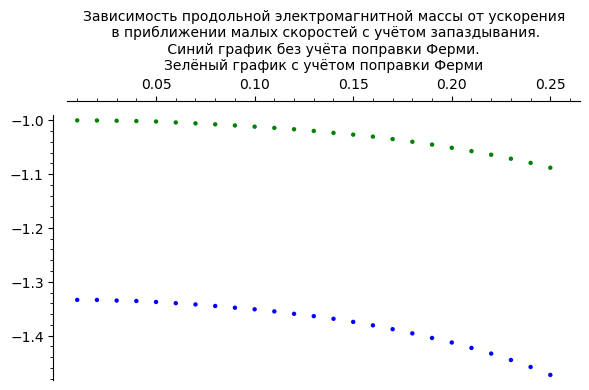

In [18]:
(
    list_plot(mass_hysteresis_lw_array) +
    list_plot(mass_hysteresis_fermi_array, color="green")
) .show(title = 
        "Зависимость продольной электромагнитной массы от ускорения\n"
        " в приближении малых скоростей с учётом запаздывания.\n"
        " Синий график без учёта поправки Ферми. \nЗелёный график с учётом поправки Ферми")

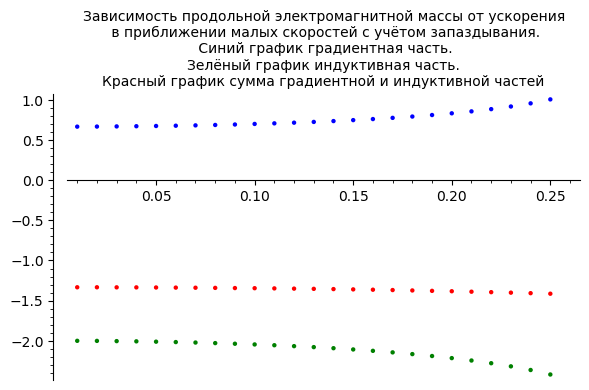

In [19]:
(
    list_plot([[v[0], v[1]] for v in mass_array]) +
    list_plot([[v[0], v[2]] for v in mass_array], color = "green") +
    list_plot([[v[0], v[1]+v[2]] for v in mass_array], color = "red")
) .show(title = 
        "Зависимость продольной электромагнитной массы от ускорения\n"
        " в приближении малых скоростей с учётом запаздывания.\n"
        " Синий график градиентная часть.\n"
        "Зелёный график индуктивная часть.\n"
        "Красный график сумма градиентной и индуктивной частей")

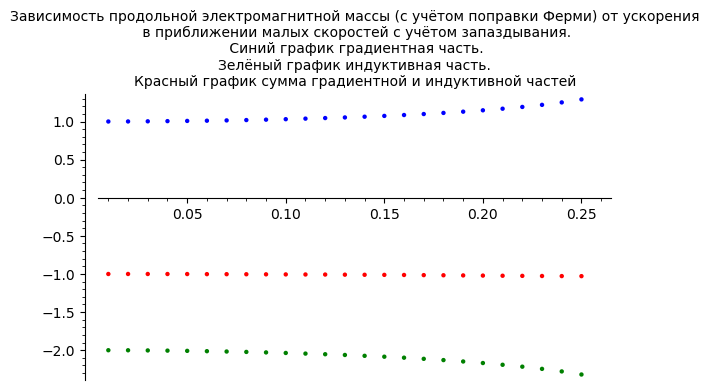

In [20]:
(
    list_plot([[v[0], v[1]] for v in mass_fermi_array]) +
    list_plot([[v[0], v[2]] for v in mass_fermi_array], color = "green") +
    list_plot([[v[0], v[1]+v[2]] for v in mass_fermi_array], color = "red")
) .show(title = 
        "Зависимость продольной электромагнитной массы (с учётом поправки Ферми) от ускорения\n"
        " в приближении малых скоростей с учётом запаздывания.\n"
        " Синий график градиентная часть.\n"
        "Зелёный график индуктивная часть.\n"
        "Красный график сумма градиентной и индуктивной частей")

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженного сферического слоя с общим зарадом $e$ и радиусом $r$ равна $\frac{2}{3} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{1}{2} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.

$^3$ Обычно говорят, что электромагнитная масса равномерно заряженной сферы с общим зарадом $e$ и радиусом $r$ равна $\frac{8}{5} \frac{e^2}{r c^2}$; если же заметить, что электростатическая энергия $u = \frac{6}{5} \frac{e^2}{r}$, то для массы находим как раз $\left(\frac{4}{3}\right) \frac{u}{c^2}$.